## Optimal Model Evaluation
### Ziad Al-Ziadi - NM427 Neural Computing

In this Notebook, we will compare our optimal MLP and optimal SVM on the test dataset to see which model performs optimally. Both the optimal MLP and SVM will be loaded in as pickle files that we created in their respective notebooks.

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.metrics import log_loss, roc_auc_score, roc_curve, auc, plot_roc_curve, plot_confusion_matrix,confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim 
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss, MSELoss
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F

import pickle

pd.set_option("display.max_rows", 250)

In [47]:
# Reading in the dataset

path = "diabetes.csv"

diabetes = pd.read_csv(path)

In [48]:
postive = diabetes.loc[diabetes["Outcome"] == 1] # has diabetes
negative = diabetes.loc[diabetes["Outcome"] == 0] # does not have 

In [49]:
postive = postive.replace({"Glucose": 0},
                            np.mean(postive["Glucose"]))

postive = postive.replace({"BloodPressure": 0},
                            np.mean(postive["BloodPressure"]))


postive = postive.replace({"SkinThickness": 0},
                            np.mean(postive["SkinThickness"]))

postive = postive.replace({"BMI": 0},
                            np.mean(postive["BMI"]))

postive = postive.replace({"Insulin": 0},
                            np.mean(postive["Insulin"]))

negative = negative.replace({"Glucose": 0},
                            np.mean(negative["Glucose"]))

negative = negative.replace({"BloodPressure": 0},
                            np.mean(negative["BloodPressure"]))

negative = negative.replace({"SkinThickness": 0},
                            np.mean(negative["SkinThickness"]))

negative = negative.replace({"BMI": 0},
                            np.mean(negative["BMI"]))

negative = negative.replace({"Insulin": 0},
                            np.mean(negative["Insulin"]))

In [50]:
diabetes = pd.concat([postive, negative])

In [51]:
y = diabetes["Outcome"]
diabetes.drop(["Outcome"], axis = 1, inplace = True)
X = diabetes

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X, X_validation, y, y_validation = train_test_split(X_train, y_train, test_size = 0.25,random_state = 42)

scaler = StandardScaler()

scaler.fit_transform(X_train)
scaler.fit_transform(X_test)
scaler.fit_transform(X_validation)

# here we convert our sets to tensors 

X_train = torch.Tensor(X_train.to_numpy())
X_test = torch.Tensor(X_test.to_numpy())
X_validation = torch.Tensor(X_validation.to_numpy())

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
X_validation = torch.FloatTensor(X_validation)

y_train = torch.LongTensor(y_train.values)
y_test = torch.LongTensor(y_test.values)
y_validation = torch.LongTensor(y_validation.values)

## Multi-Layer Perceptron

In [52]:
class MLPThree(nn.Module):
    def __init__(self,hiddenOne = 25, hiddenTwo = 20):
        super().__init__()
        self.fc1 = nn.Linear(8,hiddenOne)
        self.fc2 = nn.Linear(hiddenOne,hiddenTwo)
        self.output = nn.Linear(hiddenTwo,2)
    def forward(self,x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.output(x)
        return x

with open("optimal_mlp", "rb") as op_mlp:
    optimal_mlp = pickle.load(op_mlp)

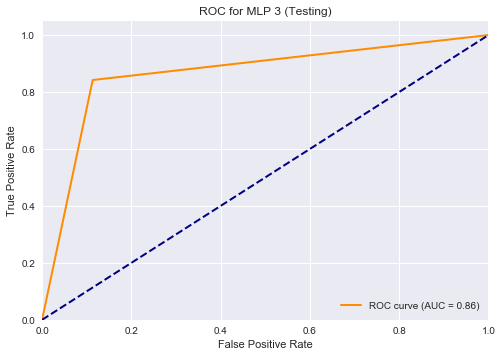

In [53]:
# Test accuracy for our optimal MLP

predictions=[]
for i,data in enumerate(X_test):
    y_pred=optimal_mlp(data)
    predictions.append(y_pred.argmax().item())

fpr, tpr, _  = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

plt.style.use("seaborn")
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for MLP 3 (Testing)')
plt.legend(loc="lower right")
plt.show()

In [54]:
acc_score = accuracy_score(y_test, predictions)
print("Accuracy score for MLP: ", acc_score*100)
print("---")
print("Classification Report for MLP:\n",classification_report(y_test, predictions))
print("---")
print("Confusion Matrix:\n", confusion_matrix(y_test,predictions ))

Accuracy score for MLP:  87.01298701298701
---
Classification Report for MLP:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90        97
           1       0.81      0.84      0.83        57

    accuracy                           0.87       154
   macro avg       0.86      0.86      0.86       154
weighted avg       0.87      0.87      0.87       154

---
Confusion Matrix:
 [[86 11]
 [ 9 48]]


## Suport Vector Machine

In [55]:
path = "diabetes.csv"

diabetes = pd.read_csv(path)

postive = postive.replace({"Glucose": 0},
                            np.mean(postive["Glucose"]))

postive = postive.replace({"BloodPressure": 0},
                            np.mean(postive["BloodPressure"]))


postive = postive.replace({"SkinThickness": 0},
                            np.mean(postive["SkinThickness"]))

postive = postive.replace({"BMI": 0},
                            np.mean(postive["BMI"]))

postive = postive.replace({"Insulin": 0},
                            np.mean(postive["Insulin"]))
                            
negative = negative.replace({"Glucose": 0},
                            np.mean(negative["Glucose"]))

negative = negative.replace({"BloodPressure": 0},
                            np.mean(negative["BloodPressure"]))


negative = negative.replace({"SkinThickness": 0},
                            np.mean(negative["SkinThickness"]))

negative = negative.replace({"BMI": 0},
                            np.mean(negative["BMI"]))

negative = negative.replace({"Insulin": 0},
                            np.mean(negative["Insulin"]))

In [56]:
y = diabetes["Outcome"]
diabetes.drop(["Outcome"], axis = 1, inplace = True)
X = diabetes

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X, X_valdation, y, y_validation = train_test_split(X_train, y_train, test_size = 0.25,random_state = 42)

scaler = StandardScaler()

scaler.fit_transform(X_train)
scaler.fit_transform(X_test)
scaler.fit_transform(X_validation)

array([[-0.55000589, -1.14041655,  0.08730665, ..., -0.50984268,
        -0.72905992, -0.90004854],
       [ 1.56751679,  1.32652046,  1.19271999, ...,  0.35311676,
         2.59987394,  0.6786243 ],
       [-0.85250913,  0.85490015,  1.19271999, ..., -0.3307378 ,
         1.56998506, -0.82111489],
       ...,
       [-1.15501238, -0.81391018, -0.83387113, ...,  0.76017316,
         0.55743437, -0.66324761],
       [-1.15501238,  0.56467227,  1.92966222, ...,  1.37889876,
        -0.53833973, -0.58431397],
       [-0.85250913, -1.7571508 , -2.30775558, ..., -1.91011675,
        -0.40310178, -0.90004854]])

In [57]:
with open("optimal_svm", "rb") as op_svm:
    optimal_svm = pickle.load(op_svm)

In [58]:
y_true_test, y_pred_test = y_test, optimal_svm.predict(X_test)

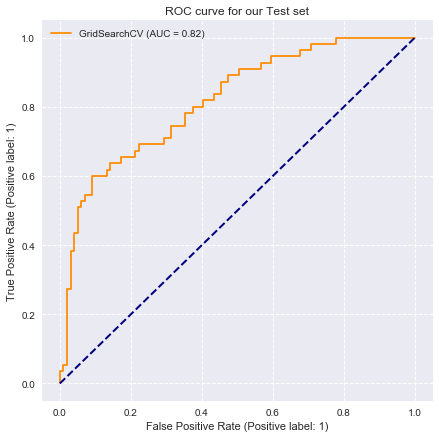

In [59]:
lw = 2
plt.style.use("seaborn")
fig, ax_roc = plt.subplots(1, figsize = (7, 7))
plot_roc_curve(optimal_svm, X_test, y_test, ax = ax_roc, color = "darkorange")
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
ax_roc.set_title('ROC curve for our Test set')
ax_roc.grid(linestyle='--')

plt.legend()
plt.show()

In [60]:
acc_score = accuracy_score(y_test, y_pred_test)
print("Test accuracy score for SVM: ", acc_score*100)
print("---")
print("Classification Report:\n", classification_report(y_true_test, y_pred_test))
print("---")
print("Confusion Matrix:\n", confusion_matrix(y_true_test, y_pred_test))

Test accuracy score for SVM:  75.32467532467533
---
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.81      0.81        99
           1       0.65      0.65      0.65        55

    accuracy                           0.75       154
   macro avg       0.73      0.73      0.73       154
weighted avg       0.75      0.75      0.75       154

---
Confusion Matrix:
 [[80 19]
 [19 36]]


# Conclusion
We can see that our MLP model outperforms our SVM model in accuracy by a very tight, almost negligible, margin. Interestingly, the SVM obtains a better AUC score. With respect to the confusion matrices, we see that with some metrics such as recall, the SVM scores better, however the confusion matrix of the MLP scores better overall. In conclusion, we can say that the MLP is narrowly more optimal than the SVM. Further, minor improvements made to the MLP will substantially improve its performance. 